# Chapter 5: Percolation, Threshold and Phase Change

Note that code in this chapter is slightly different from the book version. 

The basic logic remains the same but they are placed in more appropriate components. For example, the `render` method no longer accepts `percolating` as an argument as it is not supposed to be implemented there.

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from typing import List
from enum import Enum

class State(Enum):
    Working = 1
    Broken = 0
    Cluster = -1

## Grid class definition & helpful methods

In [88]:
WIDTH = 20
HEIGHT = 20
PROB = 0.5

class Grid:
    
    state_to_color = {State.Broken: "red",
                     State.Working: "blue",
                     State.Cluster: "grey"}
    
    def __init__(self, width = WIDTH, height = HEIGHT, prob = PROB, random_init = False):
        self.width = width
        self.height = height
        self.prob = prob
        self.states = [[State.Broken for _ in range(self.height)] for _ in range(self.width)]
        if random_init:
            self.random_init()
        self.percolated = False
        
    def random_init(self):
        for w in range(self.width):
            for h in range(self.height):
                if np.random.uniform() < self.prob:
                    self.states[w][h] = State.Working 
    
    def render(self, return_array = False, block_size = 1300):
        
        with plt.xkcd():
            fig, ax = plt.subplots(figsize=(self.width+1, self.height+1))
            if return_array:
                from matplotlib.backends.backend_agg import FigureCanvasAgg
                canvas = FigureCanvasAgg(fig)
            ax.set_xlim(0,self.width+1)
            ax.set_ylim(0,self.height+1)
            ax.axis('off')
            # draw the sites
            x, y, c = [], [], []
        
            # Note that w,h are for plotting coordiantes.
            for w in range(1,self.width+1):
                for h in range(1,self.height+1):
                    x.append(w)
                    y.append(h)
                    state = self.states[w-1][h-1]
                    c.append(Grid.state_to_color[state])
            
            plt.scatter(x, y, c = c, marker="s", s = block_size)
            
            # draw the bonds between working site
            # from bottom left, expand up and right to connect
            for w in range(1,self.width):
                for h in range(1,self.height):
                    origin_state = self.states[w-1][h-1]
                    
                    if origin_state in (State.Working, State.Cluster):
                        up_state = self.states[w-1][h]
                        if up_state in (State.Working, State.Cluster):
                            plt.plot((w, w), (h, h+1), c = Grid.state_to_color[up_state])
                        
                        right_state = self.states[w][h-1]
                        if right_state in (State.Working, State.Cluster):
                            # I am counting on my dfs algorithm to be right
                            plt.plot( (w, w+1), (h, h), c = Grid.state_to_color[right_state])
                    
            # top line
            for w in range(1,self.width):
                origin_state = self.states[w-1][self.height-1]
                right_state = self.states[w][self.height-1]
                if origin_state in (State.Working, State.Cluster) and right_state in (State.Working, State.Cluster):
                    plt.plot((w,w+1),(self.height,self.height), c = Grid.state_to_color[origin_state])
            
            # right line
            for h in range(1,self.height):
                origin_state = self.states[self.width - 1][h-1]
                up_state = self.states[self.width - 1][h]
                if origin_state in (State.Working, State.Cluster) and up_state in (State.Working, State.Cluster):
                    plt.plot((self.width,self.width),(h,h+1), c = Grid.state_to_color[origin_state]) 
     
    def filter_illegal_site(self, site):
        (w,h) = site
        if w < 0 or w >= self.width:
            return False
        if h < 0 or h >= self.height:
            return False
        return True        
    
    def dfs(self, site, visited) -> None:
        visited.add(site)
        (w,h) = site
        neighbors = [site for site in [(w-1,h),(w+1,h),(w,h-1),(w,h+1)] if self.filter_illegal_site(site)]
        for neighbor in neighbors:
            if neighbor not in visited and self.states[neighbor[0]][neighbor[1]] == State.Working:
                self.dfs(neighbor, visited)
    
    def percolate_through(self):
            clusters = []
            success = False

            for w in range(self.width):
                if len(clusters) > 1:
                    all_visited = reduce(lambda x,y: x.union(y), clusters)
                else:
                    all_visited = set() if len(clusters) == 0 else clusters[0]
                if self.states[w][0] == State.Working and (w,0) not in all_visited:
                    clusters.append(set())
                    self.dfs((w,0), clusters[-1])
                    latest_cluster = clusters[-1]
                    if max([site[1] for site in latest_cluster]) == self.height-1:
                        success = True
                        self.percolated = True
                        self.coloring(clusters[-1], success)
                        return clusters[-1], success
            return None, success
    
    def coloring(self, cluster, success):
        if success:
            self.percolated = success
            for site in cluster:
                w, h = site
                self.states[w][h] = State.Cluster

    
    def percolating_cluster_fraction(self):
        assert(self.percolated)
        total_occupied = sum([sum([h in(State.Cluster, State.Working) for h in row]) for row in self.states])
        cluster_size = sum([sum([h  == State.Cluster for h in row]) for row in self.states])
        return 1.0 * cluster_size/total_occupied
        

#### Increase system recursion depth limit

In [22]:
import sys
sys.setrecursionlimit(100000)
from functools import reduce
from tqdm import tqdm

In [99]:
grid = Grid(width=10, height = 10, random_init= True, prob = 0.492)
grid.percolate_through();

#### Check grid percolation status

In [68]:
grid.percolated

True

In [69]:
grid.percolating_cluster_fraction()

0.8787878787878788

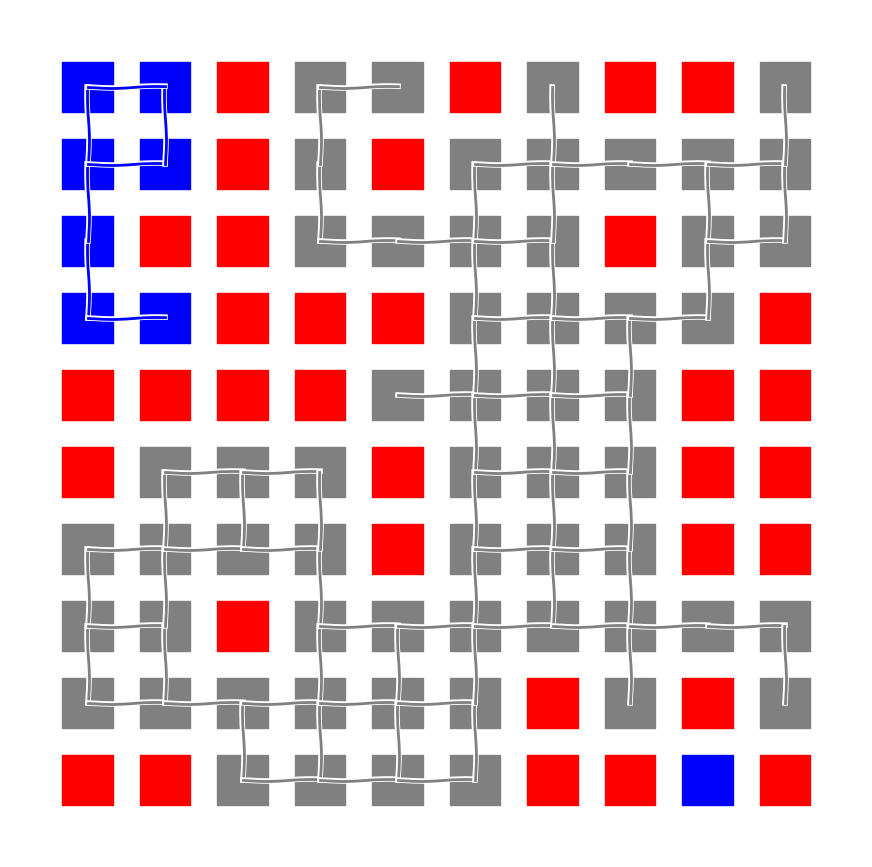

In [70]:
grid.render()

## Determining the critical probability

### 100 by 100 Grid with running occupation probabilities

In [100]:
L = 100
ROUND = 1000
p_clustering = []
low,high,num = 0.55,0.65,13
for prob in tqdm(np.linspace(low,high,num)):
    res = []
    for _ in range(ROUND):
        _, success = Grid(L, L, prob = prob, random_init = True).percolate_through()
        res.append(success)
    p_clustering.append(np.mean(res))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [03:46<00:00, 17.39s/it]


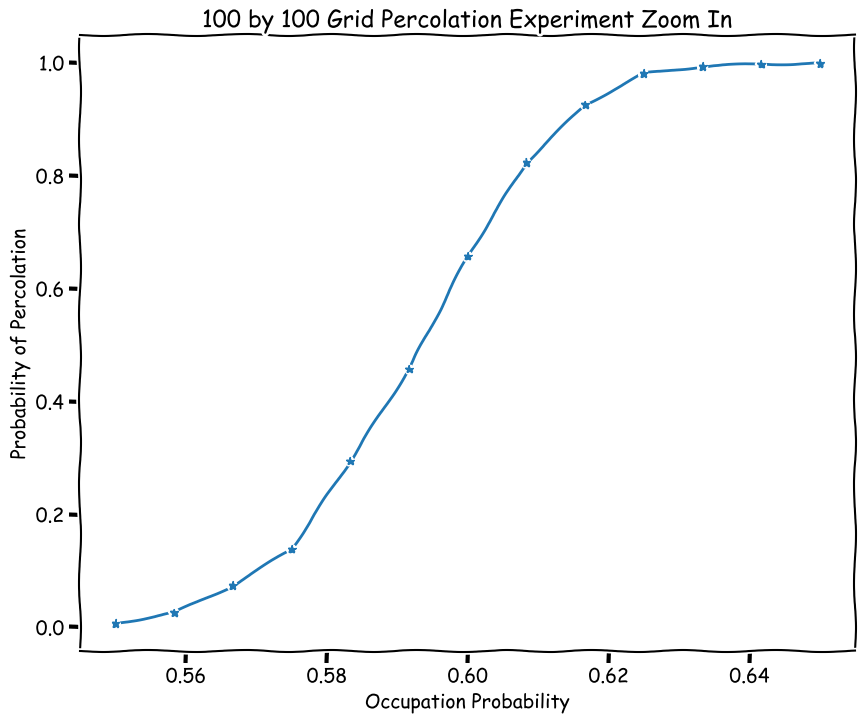

In [101]:
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(np.linspace(low,high,num), p_clustering, marker="*")
    ax.set_xlabel("Occupation Probability")
    ax.set_ylabel("Probability of Percolation")
    ax.set_title("{} by {} Grid Percolation Experiment Zoom In".format(L,L))

### Calculating the critical exponent

In [102]:
L = 100
ROUND = 1000
TRUTH = 0.592746
fractions = []
probs = []
start = 0.622746
steps = 110
step = (start - TRUTH)/(steps - 10)
for i in tqdm(range(steps)):
    res = []
    prob = start - i * step
    probs.append(prob)
    for _ in range(ROUND):
        while True:
            grid = Grid(L, L, prob = prob, random_init = True)
            grid.percolate_through()
            if grid.percolated:
                frac = grid.percolating_cluster_fraction()
                res.append(frac)
                break
        
    fractions.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [46:30<00:00, 25.37s/it]


$$F = F_0(p-p_c)^\beta$$

$$ln(F) = ln(F_0) + \beta ln(p-p_c)$$

In [103]:
probs

[0.622746,
 0.622446,
 0.622146,
 0.621846,
 0.621546,
 0.621246,
 0.620946,
 0.620646,
 0.6203460000000001,
 0.620046,
 0.619746,
 0.619446,
 0.619146,
 0.618846,
 0.618546,
 0.6182460000000001,
 0.617946,
 0.617646,
 0.6173460000000001,
 0.617046,
 0.616746,
 0.616446,
 0.616146,
 0.615846,
 0.615546,
 0.6152460000000001,
 0.614946,
 0.614646,
 0.6143460000000001,
 0.614046,
 0.613746,
 0.613446,
 0.613146,
 0.612846,
 0.612546,
 0.6122460000000001,
 0.611946,
 0.611646,
 0.6113460000000001,
 0.611046,
 0.610746,
 0.610446,
 0.610146,
 0.609846,
 0.609546,
 0.6092460000000001,
 0.608946,
 0.608646,
 0.608346,
 0.608046,
 0.607746,
 0.607446,
 0.607146,
 0.606846,
 0.606546,
 0.6062460000000001,
 0.605946,
 0.605646,
 0.605346,
 0.605046,
 0.604746,
 0.604446,
 0.604146,
 0.603846,
 0.603546,
 0.603246,
 0.602946,
 0.602646,
 0.602346,
 0.602046,
 0.601746,
 0.601446,
 0.601146,
 0.600846,
 0.600546,
 0.6002460000000001,
 0.599946,
 0.599646,
 0.599346,
 0.599046,
 0.598746,
 0.598446

In [104]:
fractions

[[0.7594407841876908,
  0.8710962396430848,
  0.4439374185136897,
  0.9181919465223619,
  0.8514113542657786,
  0.8691929602029491,
  0.8624660163121701,
  0.7711057304277643,
  0.7379773126697555,
  0.8651956836849735,
  0.8321015424164524,
  0.7755594912252455,
  0.8128478295436476,
  0.6630659253375695,
  0.8929663608562691,
  0.6839812873044039,
  0.8778171281390856,
  0.7677222311525478,
  0.8706675224646984,
  0.8457133507853403,
  0.862448198916162,
  0.8418309170874735,
  0.8648431214802896,
  0.7720742534301857,
  0.8768417680973735,
  0.8582827960421321,
  0.8169817470664928,
  0.877521613832853,
  0.8675165402614168,
  0.8203373647358371,
  0.7606673083092718,
  0.7387286920503425,
  0.8248825530536206,
  0.8344381568310428,
  0.8983564704005106,
  0.705655526992288,
  0.7206840390879479,
  0.85048358966228,
  0.5206785137318255,
  0.7329011345218801,
  0.8653784733312041,
  0.8297223559621248,
  0.7420647643475473,
  0.8638256968920218,
  0.8249840459476707,
  0.84909909909

In [105]:
ratios = [np.mean(x) for x in fractions]
ln_f = [np.log(ratio) for ratio in ratios]

In [106]:
ln_diff = [np.log(p-TRUTH) for p in probs if p > TRUTH]

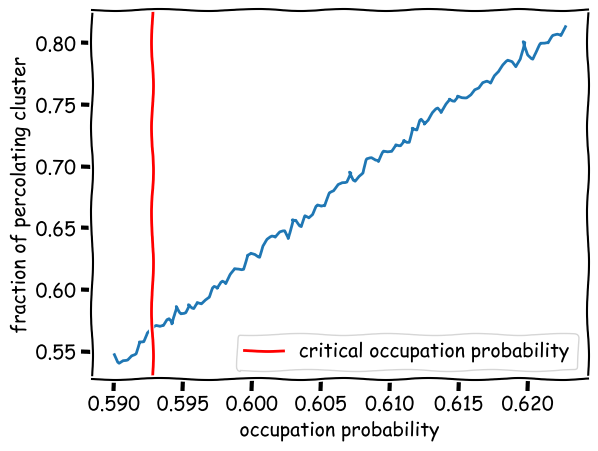

In [107]:
with plt.xkcd():
    plt.plot(probs, ratios)
    plt.axvline(TRUTH,label="critical occupation probability",c="red")
    plt.xlabel("occupation probability")
    plt.ylabel("fraction of percolating cluster")
    plt.legend()

#### 200 by 200 case

In [ ]:
L = 200
ROUND = 1000
TRUTH = 0.592746
fractions_200 = []
probs_200 = []
start = 0.622746
steps = 110
step = (start - TRUTH)/(steps - 10)
for i in tqdm(range(steps)):
    res = []
    prob = start - i * step
    probs_200.append(prob)
    for _ in range(ROUND):
        while True:
            grid = Grid(L, L, prob = prob, random_init = True)
            grid.percolate_through()
            if grid.percolated:
                frac = grid.percolating_cluster_fraction()
                res.append(frac)
                break
        
    fractions_200.append(res)

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 77/110 [1:59:53<1:14:51, 136.09s/it]

In [15]:
ratio_200s = [np.mean(x) for x in fractions_200]

In [24]:
ln_f200 = [np.log(ratio) for ratio in ratio_200s]

In [26]:
ln_diff200 = [np.log(p-TRUTH) for p in probs_200 if p > TRUTH]

In [28]:
ln_diff200

[-3.506557897319981,
 -3.516608233173481,
 -3.5267606046375017,
 -3.53701710480469,
 -3.5473798918402353,
 -3.5578511917075333,
 -3.568433301038069,
 -3.579128590154816,
 -3.58993950625903,
 -3.6008685767912234,
 -3.6119184129778072,
 -3.623091713575931,
 -3.634391268829867,
 -3.645819964653489,
 -3.6573807870545636,
 -3.6690768268177534,
 -3.6809112844647593,
 -3.692887475511474,
 -3.705008836043817,
 -3.717278928635635,
 -3.7297014486341906,
 -3.7422802308410494,
 -3.7550192566184823,
 -3.7679226614543886,
 -3.7809947430217403,
 -3.794239969771759,
 -3.8076629901039034,
 -3.8212686421596804,
 -3.8350619642920147,
 -3.849048206266758,
 -3.8632328412587134,
 -3.8776215787108113,
 -3.8922203781319675,
 -3.9070354639171065,
 -3.9220733412816453,
 -3.9373408134124324,
 -3.9528449999484017,
 -3.968593356916539,
 -3.9845936982629784,
 -4.000854219134763,
 -4.017383521085971,
 -4.034190639402351,
 -4.051285072761655,
 -4.0686768154735224,
 -4.086376392572921,
 -4.104394898075598,
 -4.1227440

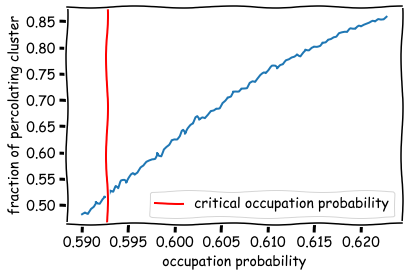

In [37]:
with plt.xkcd():
    plt.plot(probs_200, ratio_200s)
    plt.axvline(TRUTH,label="critical occupation probability",c="red")
    plt.xlabel("occupation probability")
    plt.ylabel("fraction of percolating cluster")
    plt.legend()